<a href="https://colab.research.google.com/github/ifrah9/internship/blob/main/spam_sms_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


In [ ]:
df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Retaining only the necessary columns
df.columns = ['label', 'text']

# Map 'ham' to 0 and 'spam' to 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


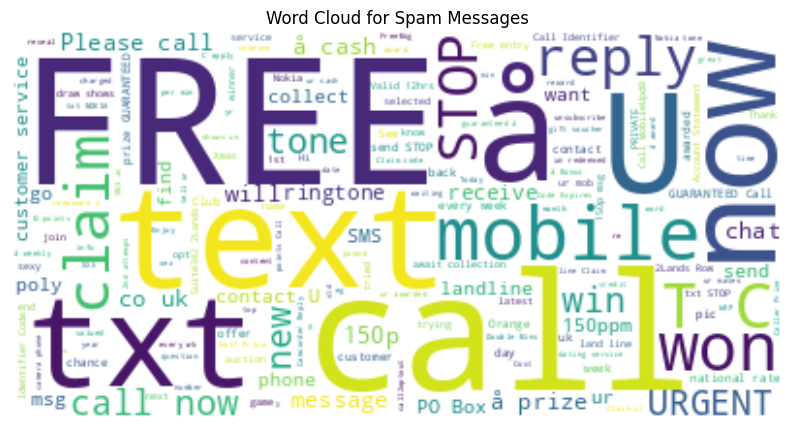

In [ ]:
from wordcloud import WordCloud
spam_messages = df[df['label'] == 1]['text'].str.cat(sep=' ')
wordcloud_spam = WordCloud(width=400, height=200, background_color='white').generate(spam_messages)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.show()


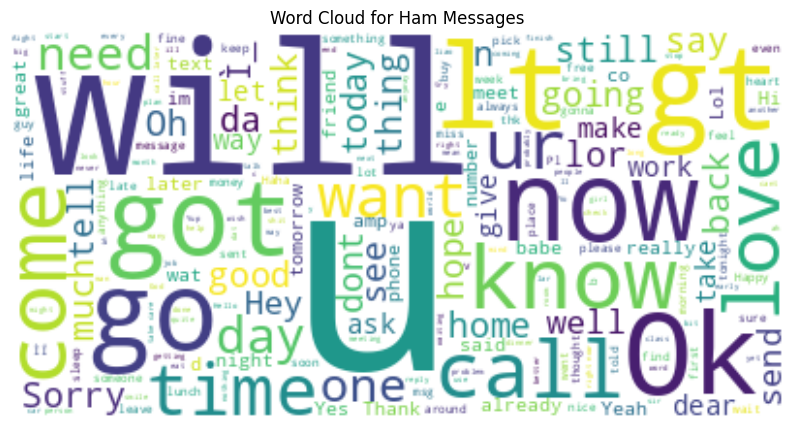

In [ ]:
ham_messages = df[df['label'] == 0]['text'].str.cat(sep=' ')
wordcloud_ham = WordCloud(width=400, height=200, background_color='white').generate(ham_messages)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, stop_words='english', max_df=0.85, min_df=2, ngram_range=(1, 3))),
    ('classifier', LinearSVC(class_weight='balanced'))
])

In [ ]:
from imblearn.pipeline import Pipeline as imPipeline

smote_pipeline = imPipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, stop_words='english', max_df=0.85, min_df=2, ngram_range=(1, 3))),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(class_weight='balanced'))
])

In [ ]:
param_grid = {
    'tfidf__max_df': [0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3],
    'classifier__C': [0.1, 1, 10],
}
grid_search = GridSearchCV(smote_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.85, min_df=2,
                                                        ngram_range=(1, 3),
                                                        stop_words='english')),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LinearSVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'tfidf__max_df': [0.75, 0.85, 0.9],
                         'tfidf__min_df': [1, 2, 3]},
             verbose=1)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__C': 10, 'tfidf__max_df': 0.75, 'tfidf__min_df': 1}


In [ ]:
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy with SVM: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Model Accuracy with SVM: 97.94%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.95      0.89      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



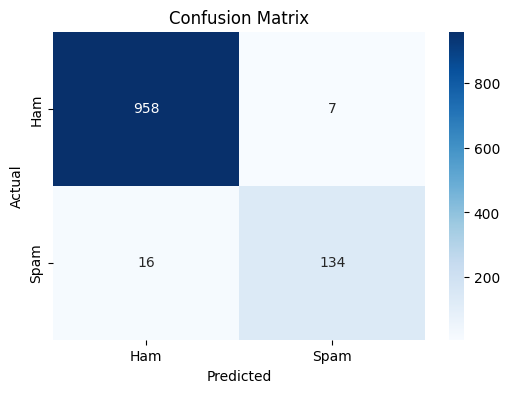

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

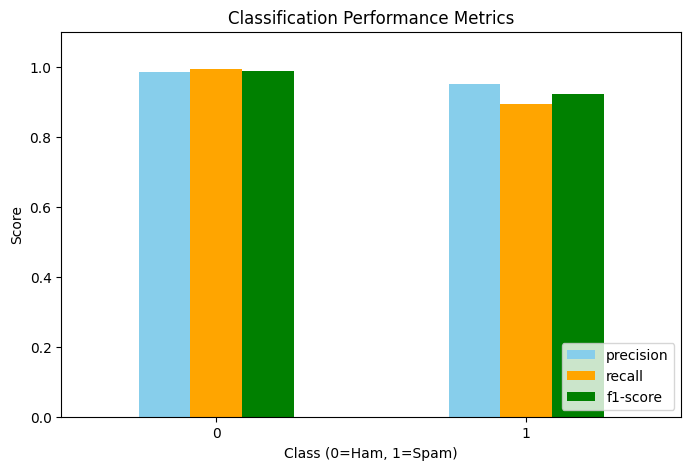

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.loc[['0', '1'], ['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(8, 5), color=['skyblue', 'orange', 'green'])
plt.title("Classification Performance Metrics")
plt.xlabel("Class (0=Ham, 1=Spam)")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

In [ ]:
def classify_message(message):
    prediction = grid_search.predict([message])[0]
    return "Spam" if prediction == 1 else "Legitimate"


In [ ]:
test_message = "You've won a prize, gift card, or coupon that you need to redeem"
print(f"Input: {test_message}")
print(f"Classification: {classify_message(test_message)}")


Input: You've won a prize, gift card, or coupon that you need to redeem
Classification: Spam


In [ ]:
while True:
    new_message = input("Enter an SMS message to classify (or type 'exit' to quit): ")
    if new_message.lower() == 'exit':
        break
    print(f"Classification: {classify_message(new_message)}")

Enter an SMS message to classify (or type 'exit' to quit): Lets meet for lunch today!
Classification: Legitimate
Enter an SMS message to classify (or type 'exit' to quit): Urgent! Your account has been compromised. Call this number immediately!"
Classification: Spam
Enter an SMS message to classify (or type 'exit' to quit): Don't forget to bring your ID card to the event tomorrow!
Classification: Legitimate
Enter an SMS message to classify (or type 'exit' to quit): you have won a free iphone!
Classification: Spam
Enter an SMS message to classify (or type 'exit' to quit): congrats on winning the race!
Classification: Legitimate
Enter an SMS message to classify (or type 'exit' to quit): exit
